# Overview of this jupyter notebook

1. Feature extraction with Encoder of Convolutional Autoencoder    
<br>1.1 Loading extracted data with ts fresh
<br>1.2 Data Preprocessing for CAE Encoder
<br>- Creating train, val and test data
<br>- Normalizing the data sets
<br>
<br>1.3 Feature Extraction with CAE Encoder
<br>- Searching the optimal CAE structure with train reconstruction loss (MAE)
<br>- Extract feature with the encoder from the optimized CAE


2. Hyperparameteroptimization of OC-SVM with extracted feature from CAE Encoder
3. Evaluate the optimized model
4. Saving results

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.svm import OneClassSVM
import optuna
import pickle
import json
import random

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization, UpSampling1D
from tensorflow.keras.layers import Conv1DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
import os
import importlib
from library import etl_helper as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
from library import autoencoder_helper as ah
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))
print(importlib.reload(ah))

<module 'library.etl_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_helper.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>
<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


In [5]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [6]:
!python -V

Python 3.10.6


# 1. Feature extraction with Encoder of Convolutional Autoencoder

## 1.1 Loading data

In [7]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [8]:
feat_train = np.load("feature_label/occ_feature_train_v2.4.npy")
feature_train = np.zeros((feat_train.shape[0], 960))   # padding the curves 920 -> 960
feature_train[:,:feat_train.shape[1]] = feat_train
feature_train.shape

(2150, 960)

In [9]:
feat_test = np.load("feature_label/occ_feature_test_v2.4.npy")
feature_test = np.zeros((feat_test.shape[0], 960))   # padding the curves 920 -> 960
feature_test[:,:feat_test.shape[1]] = feat_test
feature_test.shape

(750, 960)

In [10]:
label_train = np.load("feature_label/occ_label_train_v2.4.npy")
label_train.shape

(2150, 8)

In [11]:
label_test = np.load("feature_label/occ_label_test_v2.4.npy")
label_test.shape

(750, 8)

# 1.2 Data Preprocessing

## Creating train, val and test data

In [12]:
# using only curves from class 0 for x_train
# x_test contains 50 curves from each 15 classes

x_train = feature_train[:700]
x_test = feature_test

x_train.shape, x_test.shape

((700, 960), (750, 960))

In [13]:
y_val = np.zeros(100).astype(int)
y_val[30:] = 1
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
y_train = (np.argmax(label_train, axis=1)>0).astype(int)
y_train = y_train[:700]
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
y_test = (np.argmax(label_test, axis=1)>0).astype(int)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
(y_test==0).sum()

50

## Normalizing the data sets

In [17]:
# normalize data by dividing through np.max(x_train)

max_train = np.max(x_train)
min_train = np.min(x_train)
x_train_scaled = x_train / max_train
x_test_scaled = x_test / max_train

min_train, max_train

(0.0, 2.62528)

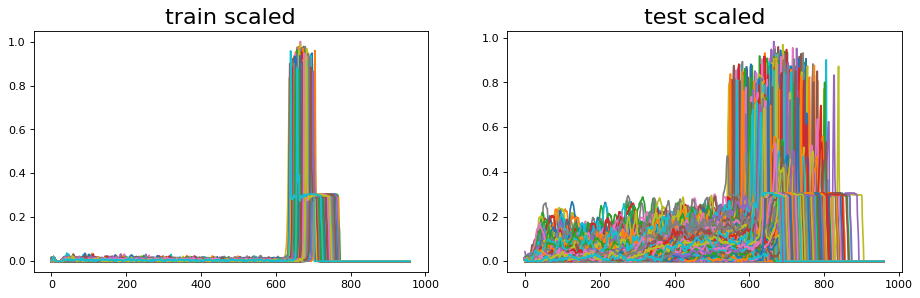

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=80)
axs[0].plot(x_train_scaled.transpose())
axs[1].plot(x_test_scaled.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("test scaled", fontsize=20)
fig.show()

In [19]:
x_train_inverse = x_train_scaled * max_train
x_test_inverse = x_test_scaled * max_train

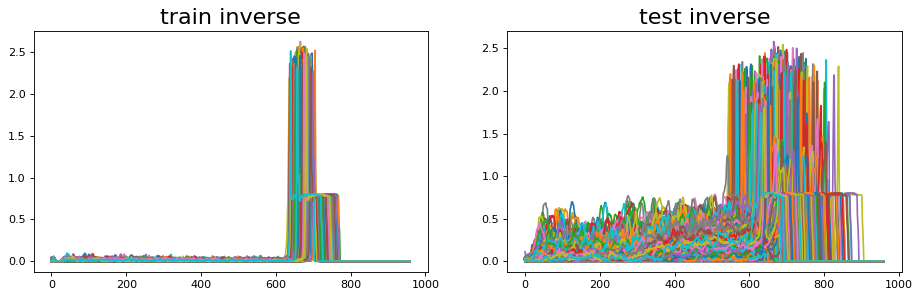

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=80)
axs[0].plot(x_train_inverse.transpose())
axs[1].plot(x_test_inverse.transpose())

axs[0].set_title("train inverse", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
fig.show()

In [21]:
# check, whether the inverse data is equal to original data

np.array_equal(np.round(x_train, 4), np.round(x_train_inverse, 4))

True

In [22]:
# reshape train and test data in 3 dim data for CNN AutoEncoder
len_curve = 960

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)

x_train_scaled = x_train_scaled.reshape(-1, len_curve, 1)
x_test_scaled = x_test_scaled.reshape(-1, len_curve, 1)

## 1.3 Feature Extraction with CAE Encoder

## Searching the optimal CAE structure with train reconstruction loss (MAE)

In [23]:
def calc_output(conv, input_size, kernel_size, strides, padding="same"):
    
    output = []
    
    for i in range(conv):
        if (strides==1) & (padding=="same"):
            if i==0:
                output.append(input_size)
            else:
                output.append(output[-1])
                
        elif (strides!=1) & (padding=="same"):
            if i==0:
                output.append(int(np.ceil(input_size/strides)))
            else:
                output.append(int(np.ceil(output[-1]/strides)))
                
    return output[-1]

In [24]:
def create_model(trial):
    
    conv = trial.suggest_int('conv_layer', 2, 4)
    filters = trial.suggest_int('filters', 16, 48, 16)
    kernel = trial.suggest_int('kernel_size', 4, 16, 4)
    strides = trial.suggest_categorical('strides', [2, 4])
    dense = trial.suggest_int('dense_layer', 0, 2)
    activation = trial.suggest_categorical('activation', ["relu", "tanh", "sigmoid"])
    bottleneck = trial.suggest_int('bottleneck', 50, 200, 50)
    
    model = Sequential()
    
    input_layer = Input(shape=(len_curve, 1))
    
    for i in range(1, conv+1):
        if i==1:
            e = Conv1D(filters, kernel, strides=strides, activation=activation,
                       padding="same")(input_layer)
        else:
            e = Conv1D(filters, kernel, strides=strides, activation=activation,
                       padding="same")(e)

    e = Flatten()(e)
    encoder_output = int(calc_output(conv, len_curve, kernel, strides)*filters)
    print(f"units: {encoder_output}, units*filters: {encoder_output*filters}")
    
    if dense>=1:
        unit1 = encoder_output//4
        e = Dense(unit1, activation=activation)(e)
    if dense>=2:
        unit2 = unit1//4
        e = Dense(unit2, activation=activation)(e)
    if dense>=3:
        unit3 = unit2//4
        e = Dense(unit3, activation=activation)(e)

    # bottleneck
    b = Dense(bottleneck, activation=activation)(e)
    
    # decoder
    if dense==1:
        d = Dense(unit1, activation=activation)(b)
    if dense==2:
        d = Dense(unit2, activation=activation)(b)
        d = Dense(unit1, activation=activation)(d)
    if dense==3:
        d = Dense(unit3, activation=activation)(b)
        d = Dense(unit2, activation=activation)(d)
        d = Dense(unit1, activation=activation)(d)
    
    for i in range(1, conv+1):
        if i==1:
            if (conv>=1) & (dense==0):
                d = Dense(encoder_output, activation=activation)(b)
                d = Reshape((-1, filters))(d)
                d = Conv1DTranspose(filters, kernel, strides=strides, activation=activation, padding="same")(d)
            elif (conv>=1) & (dense>=1):
                d = Dense(encoder_output, activation=activation)(d)
                d = Reshape((-1, filters))(d)
                d = Conv1DTranspose(filters, kernel, strides=strides, activation=activation, padding="same")(d)
        else:
            d = Conv1DTranspose(filters, kernel, strides=strides, activation=activation, padding="same")(d)
        
    output_layer = Conv1DTranspose(1, kernel, activation='sigmoid', padding="same")(d)
    
                      
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["mae"])
    print(model.summary())
    
    return model


In [25]:
def objective(trial):
    
    tf.keras.backend.clear_session()
    try:
        model = create_model(trial)
        model.fit(x_train_scaled, x_train_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=0,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

        reconstructed_train_inverse = ah.reconstruct_curves(model, x_train_scaled, max_train, len_curve, scaled=True)
        rmse, mae, mse = ah.calc_reconstruction_loss(x_train_inverse, reconstructed_train_inverse)
        print(f"MAE: {mae}")
        
    except Exception as e:
        logger.exception('Failed: ' + str(e))
    #    print("##### exception occured #####")
        mae = 10
    
    return mae

In [26]:
from optuna.samplers import TPESampler
import logging

logger=logging.getLogger()

study = optuna.create_study(sampler=TPESampler(seed=9), direction='minimize')
study.optimize(objective, n_trials=150)

[I 2023-02-09 16:01:11,624] A new study created in memory with name: no-name-fb655e2c-f275-4459-a92e-c00b481815aa


units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 100)               192100    
                                                                 
 dense_1 (Dense)             (None, 1920)              193920    
                                                                 
 reshape (Reshape)         

[I 2023-02-09 16:03:05,881] Trial 0 finished with value: 0.005934436800907366 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005934436800907366
units: 2880, units*filters: 138240
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            36912     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 720)               2074320   
                                                                 
 dense_1 (Dense)             (None, 150)               108150    
                   

[I 2023-02-09 16:03:46,063] Trial 1 finished with value: 0.007059840661030358 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 16, 'strides': 4, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 150}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.007059840661030358
units: 720, units*filters: 34560
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 48)            36912     
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 180)               129780    
                     

[I 2023-02-09 16:04:21,461] Trial 2 finished with value: 0.00777352754668654 and parameters: {'conv_layer': 3, 'filters': 48, 'kernel_size': 16, 'strides': 4, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 200}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00777352754668654
units: 720, units*filters: 34560
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 48)            36912     
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 180)               129780    
                      

[I 2023-02-09 16:04:55,974] Trial 3 finished with value: 0.007005683248091533 and parameters: {'conv_layer': 3, 'filters': 48, 'kernel_size': 16, 'strides': 4, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 100}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.007005683248091533
units: 480, units*filters: 15360
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 50)                24050     
                     

[I 2023-02-09 16:06:58,859] Trial 4 finished with value: 0.026959947901422702 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 50}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.026959947901422702
units: 3840, units*filters: 122880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 100)               384100    
                   

[I 2023-02-09 16:08:25,427] Trial 5 finished with value: 0.0060438808191443805 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0060438808191443805
units: 720, units*filters: 34560
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 48)            36912     
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 100)               72100     
                    

[I 2023-02-09 16:09:12,407] Trial 6 finished with value: 0.007015466000618298 and parameters: {'conv_layer': 3, 'filters': 48, 'kernel_size': 16, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.007015466000618298
units: 480, units*filters: 15360
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 120)               57720     
                     

[I 2023-02-09 16:10:17,281] Trial 7 finished with value: 0.010597269448553586 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 4, 'strides': 4, 'dense_layer': 2, 'activation': 'tanh', 'bottleneck': 100}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.010597269448553586
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:12:08,466] Trial 8 finished with value: 0.006012512619897365 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006012512619897365
units: 240, units*filters: 3840
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 16)            1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 16)            1040      
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 200)               48200     
                      

[I 2023-02-09 16:13:15,979] Trial 9 finished with value: 0.030921126725580887 and parameters: {'conv_layer': 3, 'filters': 16, 'kernel_size': 4, 'strides': 4, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 200}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.030921126725580887
units: 3840, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           208       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           3088      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 960)               3687360   
                                                                 
 dense_1 (Dense)             (None, 150)               144150    
                    

[I 2023-02-09 16:14:40,090] Trial 10 finished with value: 0.026688285263171657 and parameters: {'conv_layer': 2, 'filters': 16, 'kernel_size': 12, 'strides': 2, 'dense_layer': 1, 'activation': 'tanh', 'bottleneck': 150}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.026688285263171657
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:15:13,970] Trial 11 finished with value: 0.009302268609873267 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 50}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.009302268609873267
units: 960, units*filters: 15360
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           208       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           3088      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 16)           3088      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 16)            3088      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                     

[I 2023-02-09 16:16:24,615] Trial 12 finished with value: 0.006027992761880386 and parameters: {'conv_layer': 4, 'filters': 16, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 0 with value: 0.005934436800907366.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006027992761880386
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:18:02,278] Trial 13 finished with value: 0.0051058457333985376 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0051058457333985376
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 150)               288150    
                  

[I 2023-02-09 16:18:45,358] Trial 14 finished with value: 0.02762992160709062 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 1, 'activation': 'tanh', 'bottleneck': 150}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02762992160709062
units: 3840, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           208       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           3088      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 50)                192050    
                                                                 
 dense_1 (Dense)             (None, 3840)              195840    
                     

[I 2023-02-09 16:20:00,809] Trial 15 finished with value: 0.027218743909564656 and parameters: {'conv_layer': 2, 'filters': 16, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.027218743909564656
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 480)               922080    
                                                                 
 dense_1 (Dense)             (None, 100)               48100     
                    

[I 2023-02-09 16:21:03,161] Trial 16 finished with value: 0.007012430490950037 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.007012430490950037
units: 3840, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           208       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           3088      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 50)                192050    
                                                                 
 dense_1 (Dense)             (None, 3840)              195840    
                    

[I 2023-02-09 16:22:05,106] Trial 17 finished with value: 0.006092802642693176 and parameters: {'conv_layer': 2, 'filters': 16, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006092802642693176
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                   

[I 2023-02-09 16:22:59,105] Trial 18 finished with value: 0.02696710340466548 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02696710340466548
units: 2880, units*filters: 138240
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            18480     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 720)               2074320   
                                                                 
 dense_1 (Dense)             (None, 150)               108150    
                    

[I 2023-02-09 16:23:21,053] Trial 19 finished with value: 0.028581118075986 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 8, 'strides': 4, 'dense_layer': 1, 'activation': 'tanh', 'bottleneck': 150}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.028581118075986
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           416       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           12320     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                      

[I 2023-02-09 16:24:12,270] Trial 20 finished with value: 0.006100574636105733 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006100574636105733
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:25:50,301] Trial 21 finished with value: 0.005914058460514686 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005914058460514686
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:27:29,127] Trial 22 finished with value: 0.006480191512097053 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006480191512097053
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:28:50,185] Trial 23 finished with value: 0.006008456614537221 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006008456614537221
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 16:29:42,818] Trial 24 finished with value: 0.005965282486368495 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005965282486368495
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 100)               192100    
                   

[I 2023-02-09 16:30:51,810] Trial 25 finished with value: 0.006883504437939931 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006883504437939931
units: 240, units*filters: 3840
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 16)           208       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 16)            3088      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 16)            3088      
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 50)                12050     
                      

[I 2023-02-09 16:31:49,311] Trial 26 finished with value: 0.007433004406147253 and parameters: {'conv_layer': 3, 'filters': 16, 'kernel_size': 12, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.007433004406147253
units: 11520, units*filters: 552960
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 48)           18480     
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 50)                576050    
                                                                 
 dense_1 (Dense)             (None, 11520)             587520    
                  

[I 2023-02-09 16:32:33,474] Trial 27 finished with value: 0.005889060591680043 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005889060591680043
units: 5760, units*filters: 276480
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 48)           240       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 48)           9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 48)           9264      
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense (Dense)               (None, 1440)              8295840   
                   

[I 2023-02-09 16:33:03,209] Trial 28 finished with value: 0.026469537122118362 and parameters: {'conv_layer': 3, 'filters': 48, 'kernel_size': 4, 'strides': 2, 'dense_layer': 1, 'activation': 'tanh', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.026469537122118362
units: 11520, units*filters: 552960
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 48)           18480     
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 50)                576050    
                                                                 
 dense_1 (Dense)             (None, 11520)             587520    
                  

[I 2023-02-09 16:34:23,122] Trial 29 finished with value: 0.027269895183478648 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.027269895183478648
units: 2880, units*filters: 138240
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 48)           18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 48)           18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 48)            18480     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                   

[I 2023-02-09 16:34:50,752] Trial 30 finished with value: 0.00683093559109785 and parameters: {'conv_layer': 4, 'filters': 48, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00683093559109785
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                    

[I 2023-02-09 16:36:36,415] Trial 31 finished with value: 0.005937845132157621 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005937845132157621
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 200)               384200    
                                                                 
 dense_1 (Dense)             (None, 1920)              385920    
                    

[I 2023-02-09 16:38:32,297] Trial 32 finished with value: 0.0062025430461505465 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0062025430461505465
units: 2880, units*filters: 138240
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            18480     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 720)               2074320   
                                                                 
 dense_1 (Dense)             (None, 180)               129780    
                  

[I 2023-02-09 16:39:14,343] Trial 33 finished with value: 0.0072343168723804875 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 8, 'strides': 4, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0072343168723804875
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           416       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           12320     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                  

[I 2023-02-09 16:40:03,421] Trial 34 finished with value: 0.006392533157857517 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006392533157857517
units: 720, units*filters: 34560
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 48)            18480     
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 50)                36050     
                     

[I 2023-02-09 16:40:50,742] Trial 35 finished with value: 0.006318932900270259 and parameters: {'conv_layer': 3, 'filters': 48, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006318932900270259
units: 3840, units*filters: 122880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 100)               384100    
                   

[I 2023-02-09 16:41:27,699] Trial 36 finished with value: 0.006116339637341475 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006116339637341475
units: 2880, units*filters: 138240
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 48)            36912     
                                                                 
 flatten (Flatten)           (None, 2880)              0         
                                                                 
 dense (Dense)               (None, 720)               2074320   
                                                                 
 dense_1 (Dense)             (None, 50)                36050     
                   

[I 2023-02-09 16:42:00,229] Trial 37 finished with value: 0.006888244395029612 and parameters: {'conv_layer': 2, 'filters': 48, 'kernel_size': 16, 'strides': 4, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006888244395029612
units: 3840, units*filters: 122880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 960)               3687360   
                   

[I 2023-02-09 16:43:05,112] Trial 38 finished with value: 0.006998964476204435 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 150}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006998964476204435
units: 480, units*filters: 15360
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 100)               48100     
                     

[I 2023-02-09 16:45:30,742] Trial 39 finished with value: 0.027762576247565264 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 100}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.027762576247565264
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:46:28,289] Trial 40 finished with value: 0.005459464397986664 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005459464397986664
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:47:25,819] Trial 41 finished with value: 0.005631122904327684 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005631122904327684
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:48:29,702] Trial 42 finished with value: 0.00561167342018258 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00561167342018258
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                    

[I 2023-02-09 16:49:12,748] Trial 43 finished with value: 0.006288568396584806 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006288568396584806
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:49:57,824] Trial 44 finished with value: 0.005825949596185868 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005825949596185868
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:50:40,509] Trial 45 finished with value: 0.005982776852341704 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005982776852341704
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:51:03,641] Trial 46 finished with value: 0.027441480674497934 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.027441480674497934
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:51:55,426] Trial 47 finished with value: 0.005764990323841501 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005764990323841501
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 50)                384050    
                                                                 
 dense_1 (Dense)             (None, 7680)              391680    
                   

[I 2023-02-09 16:52:46,557] Trial 48 finished with value: 0.00575207180008289 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00575207180008289
units: 3840, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           1040      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 960)               3687360   
                                                                 
 dense_1 (Dense)             (None, 50)                48050     
                     

[I 2023-02-09 16:53:14,740] Trial 49 finished with value: 0.02815442034983571 and parameters: {'conv_layer': 2, 'filters': 16, 'kernel_size': 4, 'strides': 2, 'dense_layer': 1, 'activation': 'sigmoid', 'bottleneck': 50}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02815442034983571
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 16:54:09,410] Trial 50 finished with value: 0.005459168547919452 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005459168547919452
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:55:06,963] Trial 51 finished with value: 0.005464805900866477 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 13 with value: 0.0051058457333985376.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005464805900866477
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:56:03,583] Trial 52 finished with value: 0.005091448750012657 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 52 with value: 0.005091448750012657.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005091448750012657
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:57:04,136] Trial 53 finished with value: 0.004978592551971448 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.004978592551971448
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:57:59,999] Trial 54 finished with value: 0.005160249424943052 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005160249424943052
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:58:54,607] Trial 55 finished with value: 0.006555095528214882 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006555095528214882
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 16:59:55,248] Trial 56 finished with value: 0.005244857516430806 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005244857516430806
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:00:50,183] Trial 57 finished with value: 0.005365437838548596 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005365437838548596
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:01:42,268] Trial 58 finished with value: 0.005525622127794652 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005525622127794652
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 200)               384200    
                   

[I 2023-02-09 17:03:01,756] Trial 59 finished with value: 0.006871124316248711 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006871124316248711
units: 3840, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 16)           1040      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 150)               576150    
                                                                 
 dense_1 (Dense)             (None, 3840)              579840    
                    

[I 2023-02-09 17:03:48,990] Trial 60 finished with value: 0.02821370567436933 and parameters: {'conv_layer': 2, 'filters': 16, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 150}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02821370567436933
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:04:46,094] Trial 61 finished with value: 0.00548169081411172 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00548169081411172
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:05:55,722] Trial 62 finished with value: 0.005355979063170927 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005355979063170927
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:06:52,509] Trial 63 finished with value: 0.0058026656614082635 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0058026656614082635
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                  

[I 2023-02-09 17:07:50,543] Trial 64 finished with value: 0.005392502633941294 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005392502633941294
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:08:25,925] Trial 65 finished with value: 0.006104622046997932 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006104622046997932
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:09:29,528] Trial 66 finished with value: 0.00586930549254582 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 200}. Best is trial 53 with value: 0.004978592551971448.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00586930549254582
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                    

[I 2023-02-09 17:10:23,379] Trial 67 finished with value: 0.0049365852529821425 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0049365852529821425
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                  

[I 2023-02-09 17:11:12,395] Trial 68 finished with value: 0.005389998500345676 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005389998500345676
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:12:06,174] Trial 69 finished with value: 0.0050648581283331325 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0050648581283331325
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                  

[I 2023-02-09 17:12:49,377] Trial 70 finished with value: 0.005804242266060908 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005804242266060908
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:13:43,431] Trial 71 finished with value: 0.00522962231711962 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00522962231711962
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                    

[I 2023-02-09 17:14:35,267] Trial 72 finished with value: 0.005731818486744714 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005731818486744714
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           544       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           16416     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:15:17,627] Trial 73 finished with value: 0.006730055655447587 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 16, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006730055655447587
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:16:08,063] Trial 74 finished with value: 0.005652667230622785 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005652667230622785
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:17:00,289] Trial 75 finished with value: 0.005463341558854062 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005463341558854062
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:17:48,752] Trial 76 finished with value: 0.005507401849586937 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005507401849586937
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 480)               922080    
                   

[I 2023-02-09 17:19:12,879] Trial 77 finished with value: 0.0074994233102726356 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0074994233102726356
units: 3840, units*filters: 122880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 150)               576150    
                  

[I 2023-02-09 17:20:05,502] Trial 78 finished with value: 0.0269975407014882 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0269975407014882
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           416       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           12320     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                     

[I 2023-02-09 17:20:57,483] Trial 79 finished with value: 0.0058283116578155235 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0058283116578155235
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                  

[I 2023-02-09 17:21:46,549] Trial 80 finished with value: 0.006630403581135603 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006630403581135603
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:22:35,765] Trial 81 finished with value: 0.0053961945142195844 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0053961945142195844
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                  

[I 2023-02-09 17:23:25,235] Trial 82 finished with value: 0.005684700356671767 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005684700356671767
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:24:14,557] Trial 83 finished with value: 0.005334355281107673 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005334355281107673
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:25:03,961] Trial 84 finished with value: 0.005351050112348451 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005351050112348451
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 200)               384200    
                                                                 
 dense_1 (Dense)             (None, 1920)              385920    
                    

[I 2023-02-09 17:25:46,232] Trial 85 finished with value: 0.005982042524826188 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005982042524826188
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:26:34,433] Trial 86 finished with value: 0.005382310853065221 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005382310853065221
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:27:16,837] Trial 87 finished with value: 0.006221771593971686 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006221771593971686
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:28:06,436] Trial 88 finished with value: 0.005577242895206403 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005577242895206403
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:29:45,432] Trial 89 finished with value: 0.005571460729092804 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005571460729092804
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                   

[I 2023-02-09 17:30:32,446] Trial 90 finished with value: 0.005357421171682908 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005357421171682908
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:31:21,674] Trial 91 finished with value: 0.005567811074646725 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005567811074646725
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:32:11,453] Trial 92 finished with value: 0.005550909191703555 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005550909191703555
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 200)               384200    
                   

[I 2023-02-09 17:33:32,899] Trial 93 finished with value: 0.00786113980859219 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 1, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00786113980859219
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:34:22,650] Trial 94 finished with value: 0.005912948522467987 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005912948522467987
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:35:12,048] Trial 95 finished with value: 0.005698738479928294 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005698738479928294
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 200)               384200    
                                                                 
 dense_1 (Dense)             (None, 1920)              385920    
                    

[I 2023-02-09 17:35:54,422] Trial 96 finished with value: 0.006581835787561914 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006581835787561914
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:36:43,475] Trial 97 finished with value: 0.02768230610329385 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02768230610329385
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:37:32,877] Trial 98 finished with value: 0.0053086307268134176 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0053086307268134176
units: 3840, units*filters: 122880
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 150)               576150    
                  

[I 2023-02-09 17:38:40,273] Trial 99 finished with value: 0.005994275364310249 and parameters: {'conv_layer': 3, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005994275364310249
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                   

[I 2023-02-09 17:39:22,748] Trial 100 finished with value: 0.028051614308697334 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 100}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.028051614308697334
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:40:12,567] Trial 101 finished with value: 0.005580119132664338 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005580119132664338
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:41:01,746] Trial 102 finished with value: 0.005620978944472692 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005620978944472692
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:41:51,170] Trial 103 finished with value: 0.00553439278066215 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00553439278066215
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:42:40,519] Trial 104 finished with value: 0.00569578238328711 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00569578238328711
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:43:11,480] Trial 105 finished with value: 0.005872847027425815 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005872847027425815
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:44:00,874] Trial 106 finished with value: 0.00526774875353829 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00526774875353829
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                    

[I 2023-02-09 17:44:50,631] Trial 107 finished with value: 0.00571250164978358 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00571250164978358
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                    

[I 2023-02-09 17:45:39,068] Trial 108 finished with value: 0.005336778569943915 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005336778569943915
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 1920)              14747520  
                                                                 
 dense_1 (Dense)             (None, 480)               922080    
                   

[I 2023-02-09 17:46:48,807] Trial 109 finished with value: 0.00823615883461393 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 2, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00823615883461393
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 100)               192100    
                                                                 
 dense_1 (Dense)             (None, 1920)              193920    
                     

[I 2023-02-09 17:47:30,447] Trial 110 finished with value: 0.006004906480917177 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006004906480917177
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:48:19,084] Trial 111 finished with value: 0.005363455116612836 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005363455116612836
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:49:07,538] Trial 112 finished with value: 0.005292204040611319 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005292204040611319
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:49:56,156] Trial 113 finished with value: 0.005540816608431527 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005540816608431527
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:50:38,853] Trial 114 finished with value: 0.006346416100893248 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006346416100893248
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:51:27,682] Trial 115 finished with value: 0.005674894469022044 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005674894469022044
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:52:17,279] Trial 116 finished with value: 0.005725793772112497 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005725793772112497
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           416       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           12320     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:53:21,102] Trial 117 finished with value: 0.026957593528479856 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.026957593528479856
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:54:10,893] Trial 118 finished with value: 0.005449714455681823 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005449714455681823
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 17:55:00,197] Trial 119 finished with value: 0.005388559281739568 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005388559281739568
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 60, 32)            4128      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                    

[I 2023-02-09 17:55:55,655] Trial 120 finished with value: 0.005781144102920148 and parameters: {'conv_layer': 4, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005781144102920148
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:56:44,441] Trial 121 finished with value: 0.005567516224159445 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005567516224159445
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:57:32,856] Trial 122 finished with value: 0.005767581954750319 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005767581954750319
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:58:22,464] Trial 123 finished with value: 0.005322012743280897 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005322012743280897
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:59:10,690] Trial 124 finished with value: 0.006084503331979472 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006084503331979472
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 17:59:30,901] Trial 125 finished with value: 0.029017256960558676 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.029017256960558676
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:00:09,822] Trial 126 finished with value: 0.006356032565599075 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006356032565599075
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 18:00:59,208] Trial 127 finished with value: 0.005883764952973316 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 4, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005883764952973316
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 18:02:39,281] Trial 128 finished with value: 0.005061526248737851 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005061526248737851
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:04:19,159] Trial 129 finished with value: 0.005032146094737344 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005032146094737344
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 200)               1536200   
                                                                 
 dense_1 (Dense)             (None, 7680)              1543680   
                   

[I 2023-02-09 18:05:19,228] Trial 130 finished with value: 0.006268436422966021 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 200}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.006268436422966021
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:06:59,036] Trial 131 finished with value: 0.005475522791068208 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005475522791068208
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:08:38,109] Trial 132 finished with value: 0.005109714926321915 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005109714926321915
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:10:17,206] Trial 133 finished with value: 0.005478942090930831 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005478942090930831
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:11:56,049] Trial 134 finished with value: 0.00526784808457394 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.00526784808457394
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                    

[I 2023-02-09 18:13:35,157] Trial 135 finished with value: 0.005379397058880151 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005379397058880151
units: 1920, units*filters: 61440
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 240, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 150)               288150    
                                                                 
 dense_1 (Dense)             (None, 1920)              289920    
                    

[I 2023-02-09 18:15:26,598] Trial 136 finished with value: 0.005728592462840551 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 4, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005728592462840551
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:17:06,289] Trial 137 finished with value: 0.005294649272083429 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005294649272083429
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:18:43,356] Trial 138 finished with value: 0.005183394136512426 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005183394136512426
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:20:22,712] Trial 139 finished with value: 0.02749597063391393 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'sigmoid', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.02749597063391393
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 100)               768100    
                                                                 
 dense_1 (Dense)             (None, 7680)              775680    
                    

[I 2023-02-09 18:21:42,842] Trial 140 finished with value: 0.005738153723286474 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 100}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005738153723286474
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:24:06,864] Trial 141 finished with value: 0.005602384153738202 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005602384153738202
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:25:00,887] Trial 142 finished with value: 0.005704766773545134 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005704766773545134
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:26:39,693] Trial 143 finished with value: 0.005561311693958686 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005561311693958686
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:28:19,530] Trial 144 finished with value: 0.0055385501393560915 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0055385501393560915
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           416       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           12320     
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                  

[I 2023-02-09 18:29:09,372] Trial 145 finished with value: 0.005965888832322493 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 12, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005965888832322493
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:30:49,233] Trial 146 finished with value: 0.005550348719493868 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005550348719493868
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:32:23,681] Trial 147 finished with value: 0.005290659427404026 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005290659427404026
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:34:03,336] Trial 148 finished with value: 0.005713353378351854 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'tanh', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.005713353378351854
units: 7680, units*filters: 245760
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           8224      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
 dense_1 (Dense)             (None, 7680)              1159680   
                   

[I 2023-02-09 18:35:35,476] Trial 149 finished with value: 0.0055597922058198395 and parameters: {'conv_layer': 2, 'filters': 32, 'kernel_size': 8, 'strides': 2, 'dense_layer': 0, 'activation': 'relu', 'bottleneck': 150}. Best is trial 67 with value: 0.0049365852529821425.


reconstructed_curves_inverse shape: (700, 960)
MAE: 0.0055597922058198395


In [27]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df

,number,value,params_activation,params_bottleneck,params_conv_layer,params_dense_layer,params_filters,params_kernel_size,params_strides,state
0,0,0.005934,relu,100,2,0,32,8,4,COMPLETE
1,1,0.007060,relu,150,2,1,48,16,4,COMPLETE
2,2,0.007774,relu,200,3,2,48,16,4,COMPLETE
3,3,0.007006,relu,100,3,2,48,16,4,COMPLETE
4,4,0.026960,sigmoid,50,3,0,32,8,4,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
145,145,0.005966,relu,150,2,0,32,12,2,COMPLETE
146,146,0.005550,relu,150,2,0,32,8,2,COMPLETE
147,147,0.005291,relu,150,2,0,32,8,2,COMPLETE
148,148,0.005713,tanh,150,2,0,32,8,2,COMPLETE


In [28]:
study.best_params

{'conv_layer': 2,
 'filters': 32,
 'kernel_size': 4,
 'strides': 2,
 'dense_layer': 0,
 'activation': 'relu',
 'bottleneck': 150}

In [29]:
#df.to_pickle("results/occ_cae_encoder_hyperopt_v2.4.1.pkl")

## Extract feature with the encoder from the optimized CAE

In [24]:
# encoder
input_layer = Input(shape=(len_curve, 1))
e = Conv1D(32, 4, strides=2, activation="relu", padding="same")(input_layer)
e = Conv1D(32, 4, strides=2, activation="relu", padding="same")(e)
e = Flatten()(e)

# bottleneck
b = Dense(150, activation="relu")(e)


encoder = Model(inputs=input_layer, outputs=b)

print(encoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 960, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 240, 32)           4128      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 150)               1152150   
                                                                 
Total params: 1,156,438
Trainable params: 1,156,438
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

x_train_encoded.shape, x_test_encoded.shape 

((700, 150), (750, 150))

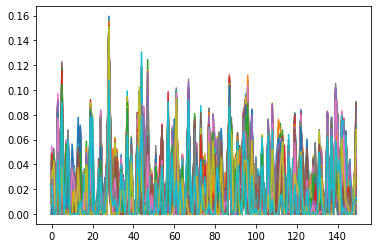

In [25]:
plt.plot(x_train_encoded.transpose())
plt.show()

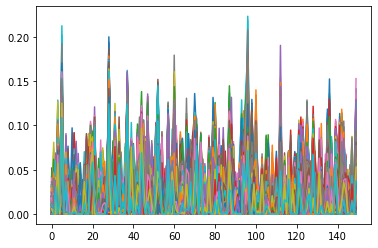

In [26]:
plt.plot(x_test_encoded[50:].transpose())
plt.show()

# 2. Hyperparameteroptimization of OC-SVM with extracted feature from CAE Encoder

In [34]:
from itertools import product

kernel = ['linear', 'rbf', 'sigmoid']
coef0 = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
gamma = ['scale','auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
nu = [0.1, 0.3, 0.5, 0.7, 0.9]

paramcom = product(kernel, coef0, gamma, nu)

In [35]:
result_hyperopt = {"kernel":[], "coef0":[], "gamma":[], "nu":[], "mean_npv":[], "mean_tnr":[], "mean_acc":[]}

In [36]:
kf = KFold(n_splits=4)

for i, com in enumerate(paramcom):
    print(f"start {i}th combination: {com}")
    npv_list=[]
    tnr_list=[]
    acc_list=[]
        
    for j, (train_index, val_index) in enumerate(kf.split(x_train_encoded)):
        print(f"fold {j} start")
        xtrain, xval = x_train_encoded[train_index], x_train_encoded[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]
    
        model = OneClassSVM(kernel=com[0], coef0=com[1], gamma=com[2], nu=com[3])
        model.fit(xtrain)
        ypred = model.predict(xval)
        ypred[ypred==1] = 0
        ypred[ypred==-1] = 1

        npv, tnr = ch.calc_metrics_occ(yval, ypred)
    
        npv_list.append(npv)
        tnr_list.append(tnr)
        acc_list.append(accuracy_score(yval, ypred))
        print(f"fold {j} end")
        
    result_hyperopt["kernel"].append(com[0])
    result_hyperopt["coef0"].append(com[1])
    result_hyperopt["gamma"].append(com[2])
    result_hyperopt["nu"].append(com[3])
    result_hyperopt["mean_npv"].append(np.mean(npv_list))
    result_hyperopt["mean_tnr"].append(np.mean(tnr_list))
    result_hyperopt["mean_acc"].append(np.mean(acc_list))
       
    print(len(npv_list), np.mean(npv_list), np.mean(tnr_list), np.mean(acc_list))    
    print(f"end {i}th combination: {com}")

start 0th combination: ('linear', 0.001, 'scale', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 0th combination: ('linear', 0.001, 'scale', 0.1)
start 1th combination: ('linear', 0.001, 'scale', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 1th combination: ('linear', 0.001, 'scale', 0.3)
start 2th combination: ('linear', 0.001, 'scale', 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 2th combination: ('linear', 0.001, 'scale', 0.5)
start 3th combination: ('linear', 0.001, 'scale', 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 3th combination: ('linear', 0.001, 'scale', 0.7)
start 

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 34th combination: ('linear', 0.001, 0.2, 0.9)
start 35th combination: ('linear', 0.001, 0.5, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 35th combination: ('linear', 0.001, 0.5, 0.1)
start 36th combination: ('linear', 0.001, 0.5, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 36th combination: ('linear', 0.001, 0.5, 0.3)
start 37th combination: ('linear', 0.001, 0.5, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 37th combination: ('linear', 0.001, 0.5, 0.5)
start 38th combination: ('linear', 0.001, 0.5, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 69th combination: ('linear', 0.01, 0.05, 0.9)
start 70th combination: ('linear', 0.01, 0.1, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 70th combination: ('linear', 0.01, 0.1, 0.1)
start 71th combination: ('linear', 0.01, 0.1, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 71th combination: ('linear', 0.01, 0.1, 0.3)
start 72th combination: ('linear', 0.01, 0.1, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 72th combination: ('linear', 0.01, 0.1, 0.5)
start 73th combination: ('linear', 0.01, 0.1, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.297142

fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 105th combination: ('linear', 0.05, 0.01, 0.1)
start 106th combination: ('linear', 0.05, 0.01, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 106th combination: ('linear', 0.05, 0.01, 0.3)
start 107th combination: ('linear', 0.05, 0.01, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 107th combination: ('linear', 0.05, 0.01, 0.5)
start 108th combination: ('linear', 0.05, 0.01, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 108th combination: ('linear', 0.05, 0.01, 0.7)
start 109th combination: ('linear', 0.05, 0.01, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 143th combination: ('linear', 0.1, 'auto', 0.7)
start 144th combination: ('linear', 0.1, 'auto', 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 144th combination: ('linear', 0.1, 'auto', 0.9)
start 145th combination: ('linear', 0.1, 0.001, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 145th combination: ('linear', 0.1, 0.001, 0.1)
start 146th combination: ('linear', 0.1, 0.001, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 146th combination: ('linear', 0.1, 0.001, 0.3)
start 147th combination: ('linear', 0.1, 0.001, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
f

fold 3 end
4 1.0 0.1 0.1
end 179th combination: ('linear', 0.1, 0.9, 0.9)
start 180th combination: ('linear', 0.2, 'scale', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 180th combination: ('linear', 0.2, 'scale', 0.1)
start 181th combination: ('linear', 0.2, 'scale', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 181th combination: ('linear', 0.2, 'scale', 0.3)
start 182th combination: ('linear', 0.2, 'scale', 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 182th combination: ('linear', 0.2, 'scale', 0.5)
start 183th combination: ('linear', 0.2, 'scale', 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.297

fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 217th combination: ('linear', 0.2, 0.5, 0.5)
start 218th combination: ('linear', 0.2, 0.5, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 218th combination: ('linear', 0.2, 0.5, 0.7)
start 219th combination: ('linear', 0.2, 0.5, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 219th combination: ('linear', 0.2, 0.5, 0.9)
start 220th combination: ('linear', 0.2, 0.9, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 220th combination: ('linear', 0.2, 0.9, 0.1)
start 221th combination: ('linear', 0.2, 0.9, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 221th com

fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 252th combination: ('linear', 0.5, 0.1, 0.5)
start 253th combination: ('linear', 0.5, 0.1, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 253th combination: ('linear', 0.5, 0.1, 0.7)
start 254th combination: ('linear', 0.5, 0.1, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 254th combination: ('linear', 0.5, 0.1, 0.9)
start 255th combination: ('linear', 0.5, 0.2, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 255th combination: ('linear', 0.5, 0.2, 0.1)
start 256th combination: ('linear', 0.5, 0.2, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 256th com

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 289th combination: ('linear', 1.0, 0.01, 0.9)
start 290th combination: ('linear', 1.0, 0.05, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 290th combination: ('linear', 1.0, 0.05, 0.1)
start 291th combination: ('linear', 1.0, 0.05, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 291th combination: ('linear', 1.0, 0.05, 0.3)
start 292th combination: ('linear', 1.0, 0.05, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 292th combination: ('linear', 1.0, 0.05, 0.5)
start 293th combination: ('linear', 1.0, 0.05, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fol

fold 3 end
4 1.0 0.5028571428571429 0.5028571428571429
end 326th combination: ('rbf', 0.001, 0.001, 0.3)
start 327th combination: ('rbf', 0.001, 0.001, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.4 0.4
end 327th combination: ('rbf', 0.001, 0.001, 0.5)
start 328th combination: ('rbf', 0.001, 0.001, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.23142857142857143 0.23142857142857143
end 328th combination: ('rbf', 0.001, 0.001, 0.7)
start 329th combination: ('rbf', 0.001, 0.001, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.05571428571428571 0.05571428571428571
end 329th combination: ('rbf', 0.001, 0.001, 0.9)
start 330th combination: ('rbf', 0.001, 0.01, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8728571428571428 0.8728571428571428
end 

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49857142857142855 0.49857142857142855
end 362th combination: ('rbf', 0.01, 'scale', 0.5)
start 363th combination: ('rbf', 0.01, 'scale', 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.2928571428571428 0.2928571428571428
end 363th combination: ('rbf', 0.01, 'scale', 0.7)
start 364th combination: ('rbf', 0.01, 'scale', 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10571428571428572 0.10571428571428572
end 364th combination: ('rbf', 0.01, 'scale', 0.9)
start 365th combination: ('rbf', 0.01, 'auto', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8999999999999999 0.8999999999999999
end 365th combination: ('rbf', 0.01, 'auto', 0.1)
start 366th combination: ('rbf', 0.01, 'auto', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49142857142857144 0.49142857142857144
end 397th combination: ('rbf', 0.01, 0.5, 0.5)
start 398th combination: ('rbf', 0.01, 0.5, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29000000000000004 0.29000000000000004
end 398th combination: ('rbf', 0.01, 0.5, 0.7)
start 399th combination: ('rbf', 0.01, 0.5, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09857142857142857 0.09857142857142857
end 399th combination: ('rbf', 0.01, 0.5, 0.9)
start 400th combination: ('rbf', 0.01, 0.9, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8885714285714286 0.8885714285714286
end 400th combination: ('rbf', 0.01, 0.9, 0.1)
start 401th combination: ('rbf', 0.01, 0.9, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6928571

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49142857142857144 0.49142857142857144
end 432th combination: ('rbf', 0.05, 0.1, 0.5)
start 433th combination: ('rbf', 0.05, 0.1, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29000000000000004 0.29000000000000004
end 433th combination: ('rbf', 0.05, 0.1, 0.7)
start 434th combination: ('rbf', 0.05, 0.1, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09857142857142857 0.09857142857142857
end 434th combination: ('rbf', 0.05, 0.1, 0.9)
start 435th combination: ('rbf', 0.05, 0.2, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8885714285714286 0.8885714285714286
end 435th combination: ('rbf', 0.05, 0.2, 0.1)
start 436th combination: ('rbf', 0.05, 0.2, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6957142

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.48857142857142855 0.48857142857142855
end 467th combination: ('rbf', 0.1, 0.01, 0.5)
start 468th combination: ('rbf', 0.1, 0.01, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.2914285714285714 0.2914285714285714
end 468th combination: ('rbf', 0.1, 0.01, 0.7)
start 469th combination: ('rbf', 0.1, 0.01, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09714285714285714 0.09714285714285714
end 469th combination: ('rbf', 0.1, 0.01, 0.9)
start 470th combination: ('rbf', 0.1, 0.05, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8842857142857143 0.8842857142857143
end 470th combination: ('rbf', 0.1, 0.05, 0.1)
start 471th combination: ('rbf', 0.1, 0.05, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.695714285

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.28714285714285714 0.28714285714285714
end 503th combination: ('rbf', 0.2, 'auto', 0.7)
start 504th combination: ('rbf', 0.2, 'auto', 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10285714285714286 0.10285714285714286
end 504th combination: ('rbf', 0.2, 'auto', 0.9)
start 505th combination: ('rbf', 0.2, 0.001, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8285714285714285 0.8285714285714285
end 505th combination: ('rbf', 0.2, 0.001, 0.1)
start 506th combination: ('rbf', 0.2, 0.001, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571429 0.5028571428571429
end 506th combination: ('rbf', 0.2, 0.001, 0.3)
start 507th combination: ('rbf', 0.2, 0.001, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3

fold 3 end
4 1.0 0.2914285714285715 0.2914285714285715
end 538th combination: ('rbf', 0.2, 0.9, 0.7)
start 539th combination: ('rbf', 0.2, 0.9, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10142857142857144 0.10142857142857144
end 539th combination: ('rbf', 0.2, 0.9, 0.9)
start 540th combination: ('rbf', 0.5, 'scale', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8871428571428572 0.8871428571428572
end 540th combination: ('rbf', 0.5, 'scale', 0.1)
start 541th combination: ('rbf', 0.5, 'scale', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6971428571428572 0.6971428571428572
end 541th combination: ('rbf', 0.5, 'scale', 0.3)
start 542th combination: ('rbf', 0.5, 'scale', 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49857142857142855 0.498

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09857142857142857 0.09857142857142857
end 574th combination: ('rbf', 0.5, 0.2, 0.9)
start 575th combination: ('rbf', 0.5, 0.5, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8899999999999999 0.8899999999999999
end 575th combination: ('rbf', 0.5, 0.5, 0.1)
start 576th combination: ('rbf', 0.5, 0.5, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6957142857142857 0.6957142857142857
end 576th combination: ('rbf', 0.5, 0.5, 0.3)
start 577th combination: ('rbf', 0.5, 0.5, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49142857142857144 0.49142857142857144
end 577th combination: ('rbf', 0.5, 0.5, 0.5)
start 578th combination: ('rbf', 0.5, 0.5, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
f

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8885714285714286 0.8885714285714286
end 610th combination: ('rbf', 1.0, 0.1, 0.1)
start 611th combination: ('rbf', 1.0, 0.1, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6971428571428571 0.6971428571428571
end 611th combination: ('rbf', 1.0, 0.1, 0.3)
start 612th combination: ('rbf', 1.0, 0.1, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.49142857142857144 0.49142857142857144
end 612th combination: ('rbf', 1.0, 0.1, 0.5)
start 613th combination: ('rbf', 1.0, 0.1, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29000000000000004 0.29000000000000004
end 613th combination: ('rbf', 1.0, 0.1, 0.7)
start 614th combination: ('rbf', 1.0, 0.1, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09857142857142857

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5071428571428572 0.5071428571428572
end 647th combination: ('sigmoid', 0.001, 0.01, 0.5)
start 648th combination: ('sigmoid', 0.001, 0.01, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.2985714285714286 0.2985714285714286
end 648th combination: ('sigmoid', 0.001, 0.01, 0.7)
start 649th combination: ('sigmoid', 0.001, 0.01, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.09857142857142857 0.09857142857142857
end 649th combination: ('sigmoid', 0.001, 0.01, 0.9)
start 650th combination: ('sigmoid', 0.001, 0.05, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8885714285714286 0.8885714285714286
end 650th combination: ('sigmoid', 0.001, 0.05, 0.1)
start 651th combination: ('sigmoid', 0.001, 0.05, 0.3)
fold 0 start
fold 0

fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.28857142857142853 0.28857142857142853
end 683th combination: ('sigmoid', 0.01, 'auto', 0.7)
start 684th combination: ('sigmoid', 0.01, 'auto', 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10285714285714286 0.10285714285714286
end 684th combination: ('sigmoid', 0.01, 'auto', 0.9)
start 685th combination: ('sigmoid', 0.01, 0.001, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.32999999999999996 0.32999999999999996
end 685th combination: ('sigmoid', 0.01, 0.001, 0.1)
start 686th combination: ('sigmoid', 0.01, 0.001, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6857142857142857 0.6857142857142857
end 686th combination: ('sigmoid', 0.01, 0.001, 0.3)
start 687th combination: ('sigmoid', 0.01, 0.001, 0.5)
fold 0 start

fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 718th combination: ('sigmoid', 0.01, 0.9, 0.7)
start 719th combination: ('sigmoid', 0.01, 0.9, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 719th combination: ('sigmoid', 0.01, 0.9, 0.9)
start 720th combination: ('sigmoid', 0.05, 'scale', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 720th combination: ('sigmoid', 0.05, 'scale', 0.1)
start 721th combination: ('sigmoid', 0.05, 'scale', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6971428571428571 0.6971428571428571
end 721th combination: ('sigmoid', 0.05, 'scale', 0.3)
start 722th combination: ('sigmoid', 0.05, 'scale', 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5 0.5
end 722

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 752th combination: ('sigmoid', 0.05, 0.2, 0.5)
start 753th combination: ('sigmoid', 0.05, 0.2, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 753th combination: ('sigmoid', 0.05, 0.2, 0.7)
start 754th combination: ('sigmoid', 0.05, 0.2, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 754th combination: ('sigmoid', 0.05, 0.2, 0.9)
start 755th combination: ('sigmoid', 0.05, 0.5, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8957142857142857 0.8957142857142857
end 755th combination: ('sigmoid', 0.05, 0.5, 0.1)
start 756th combination: ('sigmoid', 0.05, 0.5, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 788th combination: ('sigmoid', 0.1, 0.05, 0.7)
start 789th combination: ('sigmoid', 0.1, 0.05, 0.9)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 789th combination: ('sigmoid', 0.1, 0.05, 0.9)
start 790th combination: ('sigmoid', 0.1, 0.1, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8928571428571428 0.8928571428571428
end 790th combination: ('sigmoid', 0.1, 0.1, 0.1)
start 791th combination: ('sigmoid', 0.1, 0.1, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 791th combination: ('sigmoid', 0.1, 0.1, 0.3)
start 792th combination: ('sigmoid', 0.1, 0.1, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.50285714285714

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10714285714285714 0.10714285714285714
end 824th combination: ('sigmoid', 0.2, 0.001, 0.9)
start 825th combination: ('sigmoid', 0.2, 0.01, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8400000000000001 0.8400000000000001
end 825th combination: ('sigmoid', 0.2, 0.01, 0.1)
start 826th combination: ('sigmoid', 0.2, 0.01, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6885714285714286 0.6885714285714286
end 826th combination: ('sigmoid', 0.2, 0.01, 0.3)
start 827th combination: ('sigmoid', 0.2, 0.01, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5071428571428572 0.5071428571428572
end 827th combination: ('sigmoid', 0.2, 0.01, 0.5)
start 828th combination: ('sigmoid', 0.2, 0.01, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 sta

fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.10285714285714286 0.10285714285714286
end 859th combination: ('sigmoid', 0.5, 'scale', 0.9)
start 860th combination: ('sigmoid', 0.5, 'auto', 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8357142857142857 0.8357142857142857
end 860th combination: ('sigmoid', 0.5, 'auto', 0.1)
start 861th combination: ('sigmoid', 0.5, 'auto', 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6257142857142857 0.6257142857142857
end 861th combination: ('sigmoid', 0.5, 'auto', 0.3)
start 862th combination: ('sigmoid', 0.5, 'auto', 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.4828571428571429 0.4828571428571429
end 862th combination: ('sigmoid', 0.5, 'auto', 0.5)
start 863th combination: ('sigmoid', 0.5, 'auto', 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 

fold 3 end
4 1.0 0.1 0.1
end 894th combination: ('sigmoid', 0.5, 0.5, 0.9)
start 895th combination: ('sigmoid', 0.5, 0.9, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8942857142857142 0.8942857142857142
end 895th combination: ('sigmoid', 0.5, 0.9, 0.1)
start 896th combination: ('sigmoid', 0.5, 0.9, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 896th combination: ('sigmoid', 0.5, 0.9, 0.3)
start 897th combination: ('sigmoid', 0.5, 0.9, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5028571428571428 0.5028571428571428
end 897th combination: ('sigmoid', 0.5, 0.9, 0.5)
start 898th combination: ('sigmoid', 0.5, 0.9, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0.29714285714285715
end 8

fold 2 end
fold 3 start
fold 3 end
4 1.0 0.1 0.1
end 929th combination: ('sigmoid', 1.0, 0.1, 0.9)
start 930th combination: ('sigmoid', 1.0, 0.2, 0.1)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.8942857142857144 0.8942857142857144
end 930th combination: ('sigmoid', 1.0, 0.2, 0.1)
start 931th combination: ('sigmoid', 1.0, 0.2, 0.3)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.6900000000000001 0.6900000000000001
end 931th combination: ('sigmoid', 1.0, 0.2, 0.3)
start 932th combination: ('sigmoid', 1.0, 0.2, 0.5)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.5057142857142857 0.5057142857142857
end 932th combination: ('sigmoid', 1.0, 0.2, 0.5)
start 933th combination: ('sigmoid', 1.0, 0.2, 0.7)
fold 0 start
fold 0 end
fold 1 start
fold 1 end
fold 2 start
fold 2 end
fold 3 start
fold 3 end
4 1.0 0.29714285714285715 0

In [37]:
df_hp = pd.DataFrame(result_hyperopt)
df_hp.sort_values(by=["mean_acc"], ascending=False)

,kernel,coef0,gamma,nu,mean_npv,mean_tnr,mean_acc
410,rbf,0.050,auto,0.1,1.0,0.900000,0.900000
365,rbf,0.010,auto,0.1,1.0,0.900000,0.900000
455,rbf,0.100,auto,0.1,1.0,0.900000,0.900000
320,rbf,0.001,auto,0.1,1.0,0.900000,0.900000
590,rbf,1.000,auto,0.1,1.0,0.900000,0.900000
...,...,...,...,...,...,...,...
599,rbf,1.000,0.001,0.9,1.0,0.055714,0.055714
419,rbf,0.050,0.001,0.9,1.0,0.055714,0.055714
374,rbf,0.010,0.001,0.9,1.0,0.055714,0.055714
329,rbf,0.001,0.001,0.9,1.0,0.055714,0.055714


# 3. Evaluate the optimized model

In [44]:
best_model = OneClassSVM(kernel='rbf', coef0=0.05, gamma="auto", nu=0.1)
best_model.fit(x_train_encoded)

OneClassSVM(coef0=0.05, gamma='auto', nu=0.1)

In [45]:
# oc-svm model returns the prediction in -1 and 1
# so these ptrediction needs to be converted into 0 and 1

y_pred = best_model.predict(x_test_encoded)
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
y_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [46]:
print(f"recall: {recall_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")

recall: 0.8542857142857143
precision: 0.9917081260364843
f1: 0.9178818112049117
accuracy: 0.8573333333333333


In [47]:
npv, tnr = ch.calc_metrics_occ(y_test, y_pred)
print(f"negative predicted value: {npv}")
print(f"true negative rate: {tnr}")

negative predicted value: 0.30612244897959184
true negative rate: 0.9


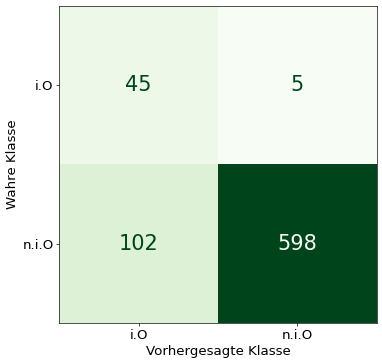

In [48]:
ch.plot_calc_cm(y_test, y_pred, class_name=["i.O", "n.i.O"], dpi=60, fontsize=16)

# 4. Saving results

In [32]:
#with open('model/occ_svm_cae_encoder_v2.4.1.pkl', 'wb') as f:
#    pickle.dump(best_model, f)

In [33]:
with open('model/occ_svm_cae_encoder_v2.4.1.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [40]:
params = {"kernel": ['linear', 'rbf', 'sigmoid'],
            "coef0": [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
            "gamma": ['scale','auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
            "nu": [0.1, 0.3, 0.5, 0.7, 0.9]}

params

{'kernel': ['linear', 'rbf', 'sigmoid'],
 'coef0': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
 'gamma': ['scale', 'auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
 'nu': [0.1, 0.3, 0.5, 0.7, 0.9]}

In [41]:
best_model.get_params()

{'cache_size': 200,
 'coef0': 0.05,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [42]:
res = ch.collect_results_occ(y_test, y_pred, algorithm="oc_svm_cae_encoder", params=params, 
                            best_param=best_model.get_params(), cm=confusion_matrix(y_test, y_pred).tolist())
res

{'algorithm': 'oc_svm_cae_encoder',
 'params': {'kernel': ['linear', 'rbf', 'sigmoid'],
  'coef0': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
  'gamma': ['scale', 'auto', 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
  'nu': [0.1, 0.3, 0.5, 0.7, 0.9]},
 'best_param': {'cache_size': 200,
  'coef0': 0.05,
  'degree': 3,
  'gamma': 'auto',
  'kernel': 'rbf',
  'max_iter': -1,
  'nu': 0.1,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False},
 'cm': [[45, 5], [102, 598]],
 'rec': 0.8542857142857143,
 'pre': 0.9917081260364843,
 'f1': 0.9178818112049117,
 'acc': 0.8573333333333333}

In [43]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "oc_svm_cae_encoder", 
                     hyperopt_result = res)

existing file occ_hyperopt_results_v2.4.1.json opened and results of oc_svm_cae_encoder saved.
